### __37.5 Challenge: sentiment analysis for Amazon reviews__

Spark and Colaboratory setup

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

In [6]:
# Install spark-related depdencies for Python
!pip install -q findspark
!pip install pyspark

In [0]:
# Set up required environment variables

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [8]:
# Point Colaboratory to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import depedencies

In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import Tokenizer, Word2Vec

# these imports are how we build and manage our data science processes: cleaning data, preparing a model,
# executing the model, and evaluating the model
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

Set constants

In [0]:
JSON_PATH = "/content/gdrive/My Drive/Thinkful-DataScience/Google Colaboratory/Colab Datasets/AmznInstantVideo.json" 
#DATA_NAME = "AmznInstantVideo.json"
APP_NAME = "Sentiment Analysis for Amazon Reviews"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

In [0]:
#The first thing we always do is create a SparkContext, and then immediately afterward 
#create a sqlContext to be able to load and manipulate an RDD/dataframe.
sc = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sqlContext = SQLContext(sc)

Load data

In [0]:
#Now that we've connected to Spark and have a sqlContext ready, it's time to 
#load our data.
amazon_df = sc.read.options(inferschema = 'true').json(JSON_PATH)

In [16]:
amazon_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [31]:
print(f"Dataset shape is {amazon_df.count():d} rows by {len(amazon_df.columns):d} columns.")

Dataset shape is 37121 rows by 9 columns.


In [22]:
import pandas as pd
pd.DataFrame(amazon_df.head(5), columns=amazon_df.columns)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000H00VBQ,"[0, 0]",2.0,I had big expectations because I love English ...,"05 3, 2014",A11N155CW1UV02,AdrianaM,A little bit boring for me,1399075200
1,B000H00VBQ,"[0, 0]",5.0,I highly recommend this series. It is a must f...,"09 3, 2012",A3BC8O2KCL29V2,Carol T,Excellent Grown Up TV,1346630400
2,B000H00VBQ,"[0, 1]",1.0,This one is a real snoozer. Don't believe anyt...,"10 16, 2013",A60D5HQFOTSOM,"Daniel Cooper ""dancoopermedia""",Way too boring for me,1381881600
3,B000H00VBQ,"[0, 0]",4.0,Mysteries are interesting. The tension betwee...,"10 30, 2013",A1RJPIGRSNX4PW,"J. Kaplan ""JJ""",Robson Green is mesmerizing,1383091200
4,B000H00VBQ,"[1, 1]",5.0,"This show always is excellent, as far as briti...","02 11, 2009",A16XRPF40679KG,Michael Dobey,Robson green and great writing,1234310400


In [18]:
#alternatively:
#import pandas as pd
#pd.DataFrame(amazon_df.take(5), columns=amazon_df.columns).transpose()

,0,1,2,3,4
asin,B000H00VBQ,B000H00VBQ,B000H00VBQ,B000H00VBQ,B000H00VBQ
helpful,"[0, 0]","[0, 0]","[0, 1]","[0, 0]","[1, 1]"
overall,2,5,1,4,5
reviewText,I had big expectations because I love English ...,I highly recommend this series. It is a must f...,This one is a real snoozer. Don't believe anyt...,Mysteries are interesting. The tension betwee...,"This show always is excellent, as far as briti..."
reviewTime,"05 3, 2014","09 3, 2012","10 16, 2013","10 30, 2013","02 11, 2009"
reviewerID,A11N155CW1UV02,A3BC8O2KCL29V2,A60D5HQFOTSOM,A1RJPIGRSNX4PW,A16XRPF40679KG
reviewerName,AdrianaM,Carol T,"Daniel Cooper ""dancoopermedia""","J. Kaplan ""JJ""",Michael Dobey
summary,A little bit boring for me,Excellent Grown Up TV,Way too boring for me,Robson Green is mesmerizing,Robson green and great writing
unixReviewTime,1399075200,1346630400,1381881600,1383091200,1234310400


In [27]:
amazon_df.describe().toPandas()

,summary,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,count,37121,37121,37121,37121,37121,36792,37121,37121
1,mean,None,4.209557932167776,None,None,None,None,1.4428786142857144E7,1.3767907963686323E9
2,stddev,None,1.1185741872746504,None,None,None,None,3.8174361192681804E7,3.0549835612023447E7
3,min,B000H00VBQ,1.0,"""13 Assassins"" is a remake of a 1963 film, upd...","01 1, 2007",A0705654XT5UCAYOY7TH,"Leah ""Leah""",!!!!,975456000
4,max,B00LPWPMCS,5.0,~Why only ten episodes? This is the first fant...,"12 9, 2013",AZXS6P5QWNMLC,zzdb,~HUGE FAN HERE!,1406073600


In [28]:
#Get summary numeric (double) column
numeric_features = [t[0] for t in amazon_df.dtypes if t[1] == 'double']
amazon_df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
overall,37121,4.209557932167776,1.1185741872746504,1.0,5.0


In [35]:
amazon_df.registerTempTable('reviews')
sqlContext.sql("select overall, count(overall) as reviewCount from reviews group by overall order by overall desc").show()

+-------+-----------+
|overall|reviewCount|
+-------+-----------+
|    5.0|      20888|
|    4.0|       8445|
|    3.0|       4185|
|    2.0|       1885|
|    1.0|       1718|
+-------+-----------+



Let's recode the overall score to positive or negative

* Positive: overall > 3
* Negative: overall <= 3

In [0]:
udf = UserDefinedFunction(lambda x: 1 if x > 3.0 else -1, IntegerType())
amazon_df = amazon_df.withColumn("overall_recode", udf(amazon_df.overall))

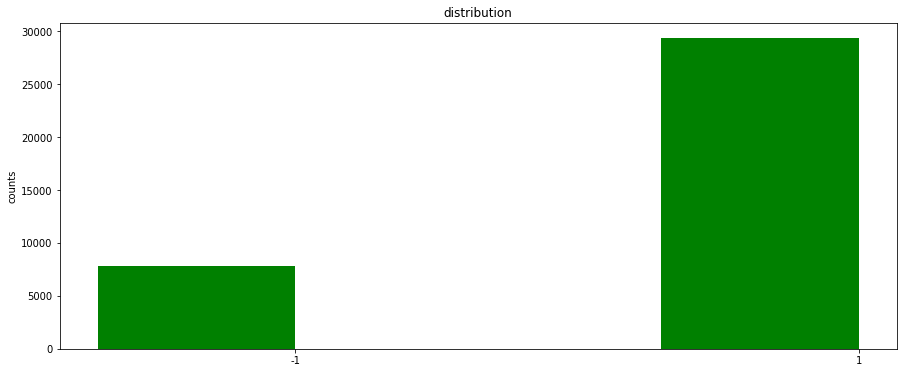

In [37]:
#Plot two labels

plt.rcParams['figure.figsize'] = (15,6)

statuses = amazon_df.groupBy('overall_recode').count().collect()

categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]

ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='g')

plt.ylabel('counts')
plt.title('distribution')
plt.xticks(ind + width/2., categories)
plt.show()

In [38]:
amazon_df.select("overall", "overall_recode", "summary", "reviewText").show(10)

+-------+--------------+--------------------+--------------------+
|overall|overall_recode|             summary|          reviewText|
+-------+--------------+--------------------+--------------------+
|    2.0|            -1|A little bit bori...|I had big expecta...|
|    5.0|             1|Excellent Grown U...|I highly recommen...|
|    1.0|            -1|Way too boring fo...|This one is a rea...|
|    4.0|             1|Robson Green is m...|Mysteries are int...|
|    5.0|             1|Robson green and ...|This show always ...|
|    5.0|             1|I purchased the s...|I discovered this...|
|    3.0|            -1|It takes up your ...|It beats watching...|
|    3.0|            -1|A reasonable way ...|There are many ep...|
|    5.0|             1|           kansas001|This is the best ...|
|    3.0|            -1| Entertaining Comedy|Not bad.  Didn't ...|
+-------+--------------+--------------------+--------------------+
only showing top 10 rows



In [0]:
tokenizer = Tokenizer(inputCol='reviewText', outputCol="tokenized_text").transform(amazon_df)

word2Vec = Word2Vec(vectorSize=300, seed=42, inputCol="tokenized_text", outputCol="w2v_vector").fit(tokenizer)

w2vdf = word2Vec.transform(tokenizer)

In [40]:
w2vdf.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- overall_recode: integer (nullable = true)
 |-- tokenized_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- w2v_vector: vector (nullable = true)



In [41]:
w2vdf.select("overall_recode", "reviewText", "tokenized_text", "w2v_vector").show(10)

+--------------+--------------------+--------------------+--------------------+
|overall_recode|          reviewText|      tokenized_text|          w2v_vector|
+--------------+--------------------+--------------------+--------------------+
|            -1|I had big expecta...|[i, had, big, exp...|[-0.0386027075583...|
|             1|I highly recommen...|[i, highly, recom...|[0.03085500549059...|
|            -1|This one is a rea...|[this, one, is, a...|[0.00350296836292...|
|             1|Mysteries are int...|[mysteries, are, ...|[0.00306359282694...|
|             1|This show always ...|[this, show, alwa...|[0.00180407294192...|
|             1|I discovered this...|[i, discovered, t...|[0.00200728614325...|
|            -1|It beats watching...|[it, beats, watch...|[-0.0376871883403...|
|            -1|There are many ep...|[there, are, many...|[-0.0319872667490...|
|             1|This is the best ...|[this, is, the, b...|[-0.0174919149108...|
|            -1|Not bad.  Didn't ...|[no

Building models

In [0]:
#Random Forest

# Build the training indexers/split data/classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="overall_recode", outputCol="indexedLabel").fit(w2vdf)

# now generate the indexed feature vector.
featureIndexer = VectorIndexer(inputCol="w2v_vector", outputCol="indexedFeatures", maxCategories=4).fit(w2vdf)

# Split the data into training and validation sets (20% held out for testing)
(trainingData, testData) = w2vdf.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [0]:
# Train model
rf_model = pipeline.fit(trainingData)

# Make predictions
predictions = rf_model.transform(testData)

Evaluation

In [44]:
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test Error = {}".format(1.0 - accuracy))
print("Accuracy = {}".format(accuracy))

Test Error = 0.20982202596012312
Accuracy = 0.7901779740398769


Considering class imbalance (0.79 = positive), this is not an impressive result. Balancing classes and then running the model again would be a good exercise.